In [1]:
import os  # helps you to interact with operating system, 
# managing files and directories 
# finding current directories, 
# working with enviornment variables 
import pandas as pd  # for dataframe 
import numpy as np  # handaling arrays
import cv2  # used for image processing and computer vision
# read and write files, Object detections(faces) and more 
import matplotlib.pyplot as plt 
from tqdm import tqdm # shows the level of progress
import random 
import concurrent.futures # for parallel execution of tasks 

In [2]:
train_path = "/Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/train"

print("Classes: ",sorted(os.listdir(train_path)))

Classes:  ['0', '1', '2', '3', '4']


## Sample Image

(-0.5, 1023.5, 730.5, -0.5)

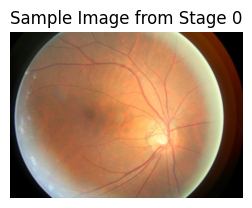

In [3]:
sample_imgpath = os.path.join(train_path,"0",os.listdir(os.path.join(train_path,"0"))[0])

# read image using OpenCV
img = cv2.imread(sample_imgpath) # cv2 loads image in BGR format only by default 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.title("Sample Image from Stage 0")
plt.axis("off")

## Creating Dataset

Resource already had categorised images into train test and validation sets, to avoid preprocessing these folders individually will combine them into one and split it after preprocessing them to maintain the consistency 

In [4]:
dataset_path = "/Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2"
folders = ["train","test","val"]

image_paths = []
labels = []

for folder in folders:
    folder_path = os.path.join(dataset_path,folder)
    for category in sorted(os.listdir(folder_path)):
        category_path = os.path.join(folder_path,category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path,img_name)
            image_paths.append(img_path)
            labels.append(int(category))

# unified dataframe
df = pd.DataFrame({"image_path": image_paths, "label":labels})
df.head()

,image_path,label
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0


## Distribution of Images 

In [5]:
df.shape

(92501, 2)

In [6]:
# Check number of images per stage 

image_counts = df['label'].value_counts().sort_index()
image_counts

label
0    68953
1     4634
2    15151
3     1259
4     2504
Name: count, dtype: int64

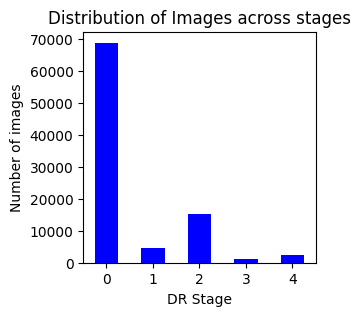

In [7]:
# Plot distribution of images 
plt.figure(figsize=(3,3))

image_counts.plot(kind='bar',color='blue')
plt.xlabel("DR Stage")
plt.ylabel("Number of images")
plt.xticks(rotation=0)
plt.title("Distribution of Images across stages")
plt.show()

This shows that our dataset is highly imbalanced. There are more number of images of stage 0 which might build our model biased

## Identifying and removing corrupted images if any

In [8]:
# Function to calculate images if any 

def is_corrupted(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return True  # image is corrupted 
        return False 
    except:
        return True 
    
# Detect corrupted images 
corrupted_images = [img_path for img_path in df['image_path'] if is_corrupted(img_path)]

In [9]:
# Display results 
print(f"Total images checked:{len(df)}")
print(f"Corrupted images found:{len(corrupted_images)}")

df = df[~df["image_path"].isin(corrupted_images)].reset_index(drop=True)

Total images checked:92501
Corrupted images found:0


## Identifying and removing duplicates if any

In [10]:
# Function to calculate image hash (for detecting duplicates)
def dhash(image, hash_size=8): # 64 bit hash representation of image
    resized = cv2.resize(image, (hash_size+1, hash_size)) # side by side comparison at the end 8 by 8 recieved
    diff = resized[:,1:] > resized[:,:-1]
    return sum([2 ** i for (i,v) in enumerate(diff.flatten()) if v])

# Dictionary to store unique image hashes 
hashes = {}
duplicate_images = []

# Iterate through all images in the dataset with tqdm for process tracking
for img_path in tqdm(df["image_path"],desc="processing images"):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # read in grayscale for consistency 

    img_hash = dhash(img) # compute hash 

    if img_hash in hashes:
        duplicate_images.append(img_path) # Mark as duplicate
    else:
        hashes[img_hash] = img_path

duplicate_set = set(duplicate_images)

# drop duplicates from the dataframe 
df = df[~df["image_path"].isin(duplicate_set)].reset_index(drop=True)

# display results
print(f"Total images checked:{len(hashes)} (unique)")
print(f"Duplicate images removed:{len(duplicate_images)}")

processing images: 100%|██████████| 92501/92501 [05:21<00:00, 287.59it/s]

Total images checked:90366 (unique)
Duplicate images removed:2135


In [11]:
# Check the number of images per stage 
image_counts = df["label"].value_counts().sort_index()
print("Number of images per stage:")
print(image_counts)

Number of images per stage:
label
0    67556
1     4470
2    14676
3     1225
4     2439
Name: count, dtype: int64


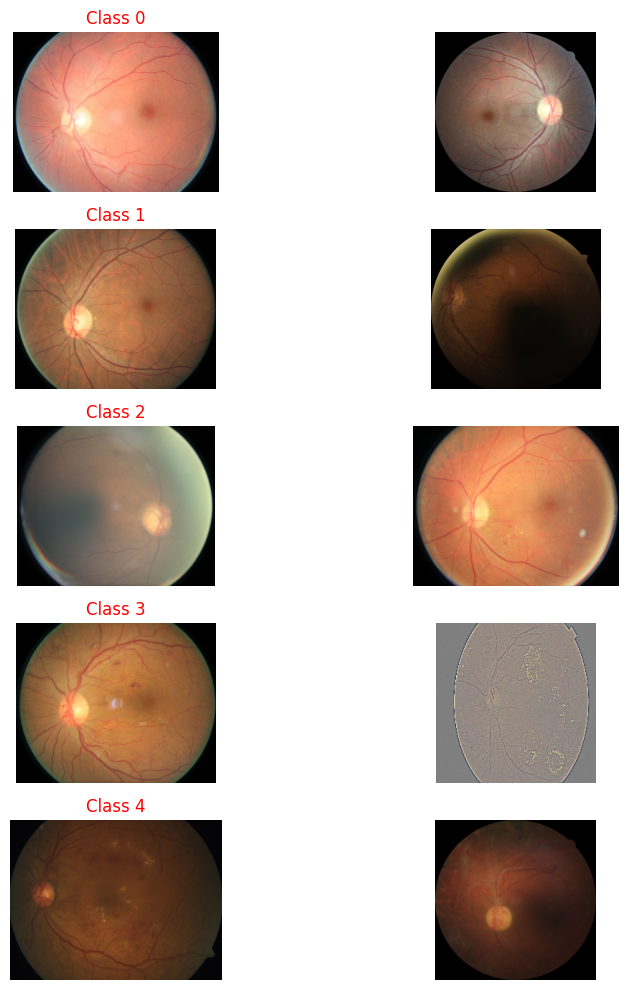

In [12]:
# Visualzing sample Images 

img_perclass = 2 
unique_labels = df["label"].unique()
fig, axes = plt.subplots(len(unique_labels), img_perclass, figsize=(10,10))

for i, label in enumerate(sorted(unique_labels)):
     sample_images = df[df['label'] == label]['image_path'].sample(img_perclass, random_state=42).tolist()
     for j, image_path in enumerate(sample_images):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(f"Class {label}", fontsize=12, color='red')

plt.tight_layout()
plt.show()


#### Interpretations

1. Few images are blurry with low contrast whereas some are clear and well-lit
2. Class 1 second images seems to be poorly processed
3. Images would also need rotation and flipping
4. Images are of same resolution?
5. There is a visible progression of Diabetic Retinopathy severity as we move down to stage 4


## Resizing Images

In [13]:
# Function to get image size 
def get_image_size(image_path):
    img = cv2.imread(image_path)
    return img.shape[:2]

stages = df["label"].unique()

for stage in stages:
    stage_images = df[df["label"]==stage]["image_path"].tolist()

    random_images = random.sample(stage_images, 4) # want 4 from each

    print(f"\nStage: {stage}")
    for img_path in random_images:
        size = get_image_size(img_path)
        print(f"Size: {size}")


Stage: 0
Size: (823, 1024)
Size: (1021, 1024)
Size: (1016, 1024)
Size: (1001, 1024)

Stage: 1
Size: (990, 1024)
Size: (820, 1024)
Size: (806, 1023)
Size: (1736, 2416)

Stage: 2
Size: (1020, 1024)
Size: (990, 1023)
Size: (1018, 1024)
Size: (1016, 1024)

Stage: 3
Size: (1021, 1024)
Size: (962, 1024)
Size: (851, 1024)
Size: (224, 224)

Stage: 4
Size: (224, 224)
Size: (1016, 1024)
Size: (224, 224)
Size: (757, 1024)


1. Since images are of different sizes, resizing ensures they are on the same scale
2. Many pretrained models require a fixed input size, and 224×224 is a common standard

In [14]:
# Function to resize an image to 224*224

def resize_image(image_path):
    try:
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img,(224,224))
        return image_path, img_resized
    except:
        return image_path, None # Skip images if any issue occurs

# Multiprocessing function
def resize_images_parallel(image_paths, max_workers=4):
    resized_images = {}

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = executor.map(resize_image, image_paths)

        for image_path, resized in results:
            if resized is not None:
                resized_images[image_path] = resized  # Store valid resized images

    return resized_images
# Get all image paths from the DataFrame
image_paths = df["image_path"].tolist()

# Run multiprocessing resizing
resized_images_dict = resize_images_parallel(image_paths, max_workers=4)

# Update DataFrame with resized images
df["resized_image"] = df["image_path"].map(resized_images_dict)

print(f"Successfully resized {len(resized_images_dict)} images to 224x224!")

Successfully resized 90366 images to 224x224!


In [15]:
df.head()

,image_path,label,resized_image
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [16]:
df_resized = df.copy()  # Create a new DataFrame for resized images

In [17]:
df_resized.to_pickle("df_resized.pkl")  # Saves the DataFrame

In [2]:
df_resized = pd.read_pickle('df_resized.pkl')

In [3]:
df_resized.head(2)

,image_path,label,resized_image
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."


## Lets resolve the variation amng images 

In [4]:
# Function to analuze an image 
def analyze_image(img):

    # Check if the image is grayscale 
    is_grayscale = len(img.shape) == 2 or (len(img.shape)==3 and img.shape[2] == 1)

    if is_grayscale:
        return {
            "is_grayscale": True,
            "color_bias":"Grayscale",
            "mean_intensity":np.mean(img),
        }
    
    # Compute mean intensity for each channel (BGR format)
    blue_mean = np.mean(img[:,:,0]) 
    green_mean = np.mean(img[:,:,1])
    red_mean = np.mean(img[:,:,2])

    # Determine color bias 
    if green_mean > blue_mean and green_mean > red_mean:
        color_bias = "Green Dominant"
    elif red_mean > blue_mean and red_mean > green_mean:
        color_bias = "Red Dominant"
    elif blue_mean > green_mean and blue_mean > red_mean:
        color_bias = "Blue Dominant"
    else:
        color_bias = "No Dominant Color"

    # Compute overall mean intensity (brightness) and tell us which color is dominant
    mean_intensity = np.mean(img)

    return {
        "is_grayscale": False,
        "color_bias": color_bias,
        "mean_intensity":mean_intensity

    }

In [5]:
# Function to analyze the entire dataset 
def analyze_dataset(df_resized):
    results=[]

    # Iterate over the dataframe with a progress bar 
    for _, row in tqdm(df_resized.iterrows(), total=len(df_resized),desc="Analyzing Images"):
        img = row["resized_image"]

        # Analyze the image 
        result = analyze_image(img)
        results.append(result)

    # Convert results to a dataframe 
    results_df = pd.DataFrame(results)

    # Compute percentages
    color_bias_counts = results_df["color_bias"].value_counts(normalize=True)*100
    exposure_counts = pd.cut( # cut() helps to place numerical values in the bins
        results_df["mean_intensity"],
        bins=[0,50,200,255],
        labels=["Underexposed","Normal","Overexposed"]

    ).value_counts(normalize=True) * 100

    # Compute percentage of grayscale images
    grayscale_percentage = (results_df["is_grayscale"].sum()/len(results_df))

    return color_bias_counts, exposure_counts , grayscale_percentage

color_bias_percentages, exposure_percentages, grayscale_percentage = analyze_dataset(df_resized)

print("Color Bias Percentages:")
print(color_bias_percentages)

print("\nExposure Percentages:")
print(exposure_percentages)

print("\nPercentage of Grayscale Images:")
print(f"{grayscale_percentage:.2f}%")


Analyzing Images: 100%|██████████| 90366/90366 [01:09<00:00, 1299.41it/s]


Color Bias Percentages:
color_bias
Red Dominant      99.248611
Green Dominant     0.597570
Blue Dominant      0.153819
Name: proportion, dtype: float64

Exposure Percentages:
mean_intensity
Normal          84.156652
Underexposed    15.838922
Overexposed      0.004426
Name: proportion, dtype: float64

Percentage of Grayscale Images:
0.00%


#### found that 15 percent of images are too dark, so to resolve this issue we use CLAHE to enhance the contrast of underexposed images

In [6]:
# Function to apply CLAHE to an image
def apply_clahe(img):
    # Convert the image to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab) # 1.step in CLAHE L(Lightness) A(Green-Red) B(Blue-Yellow) 

    # Apply CLAHE to the L-Channel 
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8)) # cliplimit fine tuned from 2.0 to 4.0 since 4percent of too dark images were still present 
    l_clahe = clahe.apply(l)

    # Merge the enhanced L-channel with A and B channels
    lab_clahe = cv2.merge([l_clahe, a, b])

    # Convert back to RGB
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    return img_clahe

def apply_clahe_to_dataset(df_resized):
    df_resized["clahe_image"] = None

    # Iterate over the Dataframe with a progress bar 
    for idx, row in tqdm(df_resized.iterrows(), total=len(df_resized), desc="Applying CLAHE"):
        img = row["resized_image"] # Access the resized image directly 

        # Apply CLAHE to the image 
        img_clahe = apply_clahe(img)

        # Store the CLAHE-enhanced image in the new column 
        df_resized.at[idx, "clahe_image"] = img_clahe

    return df_resized

df_resized = apply_clahe_to_dataset(df_resized)
        

Applying CLAHE: 100%|██████████| 90366/90366 [01:59<00:00, 753.54it/s] 


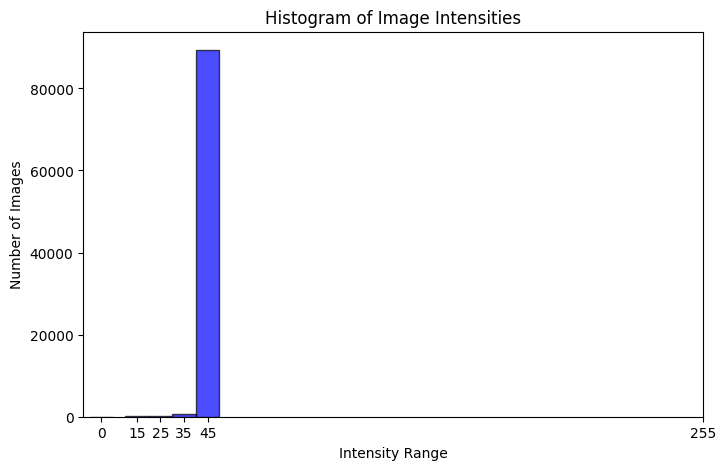

Images with intensity between 0-15: 12
Images with intensity between 15-25: 72
Images with intensity between 25-35: 292
Images with intensity between 35-45: 648
Images with intensity between 45-255: 89342


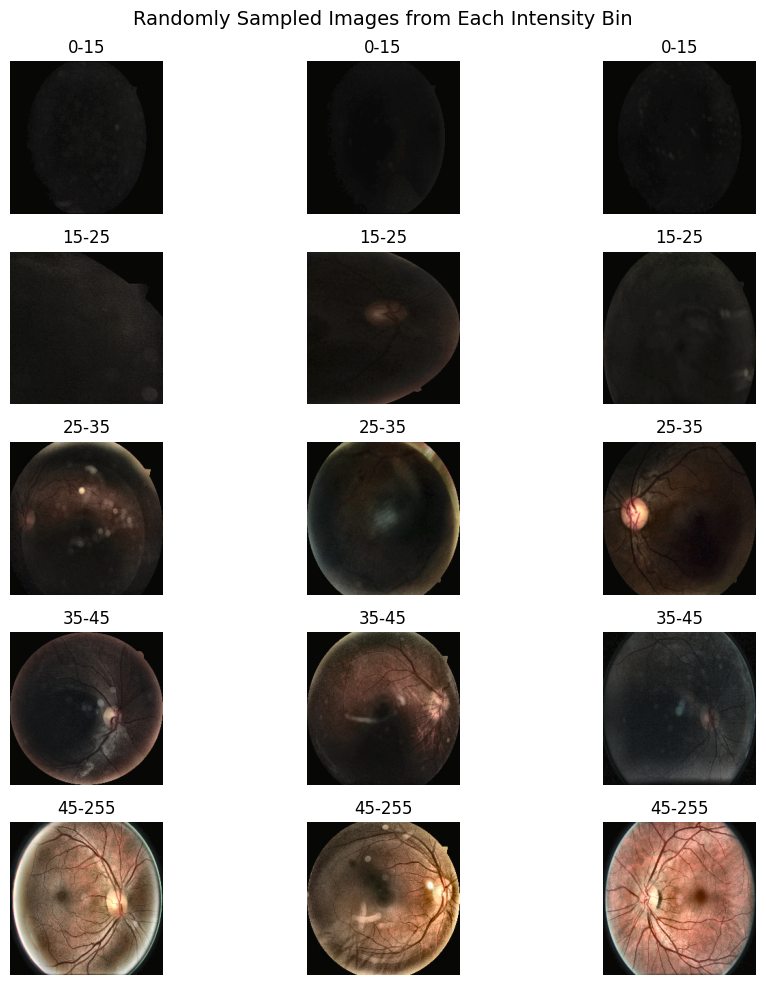

In [10]:
# Compute average intensity for each image in df_resized["resized_image"]
df_resized["avg_intensity"] = df_resized["clahe_image"].apply(lambda img: np.mean(img))

# Define intensity bins
bins = [0, 15, 25, 35, 45, 255]  # Last bin covers all above 45
hist, bin_edges = np.histogram(df_resized["avg_intensity"], bins=bins)

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.bar(bin_edges[:-1], hist, width=10, alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Intensity Range")
plt.ylabel("Number of Images")
plt.title("Histogram of Image Intensities")
plt.xticks(bins)
plt.show()

# Inspecting images in different bins
for lower, upper in zip(bins[:-1], bins[1:]):
    sample_images = df_resized[(df_resized["avg_intensity"] >= lower) & (df_resized["avg_intensity"] < upper)]
    print(f"Images with intensity between {lower}-{upper}: {len(sample_images)}")

# Sample images from each bin
sampled_images = {}
for lower, upper in zip(bins[:-1], bins[1:]):
    bin_images = df_resized[(df_resized["avg_intensity"] >= lower) & (df_resized["avg_intensity"] < upper)]
    sampled_images[(lower, upper)] = bin_images.sample(n=min(3, len(bin_images)), random_state=42)["clahe_image"].tolist()

# Plot sampled images
fig, axes = plt.subplots(len(sampled_images), 3, figsize=(10, 10))
fig.suptitle("Randomly Sampled Images from Each Intensity Bin", fontsize=14)

for i, ((lower, upper), images) in enumerate(sampled_images.items()):
    for j, img in enumerate(images):
        axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i, j].axis("off")
        axes[i, j].set_title(f"{lower}-{upper}")

plt.tight_layout()
plt.show()

#### Removing extremely dark images which wont enhance at any cost 
 The images with avg intensity of 0-25 are not at all interpretable after applying CLAHE 

In [12]:
def remove_dark_images(df_resized, brightness_threshold=25):
    """Removes images that are too dark"""
    def is_too_dark(img):
        return np.mean(img) < brightness_threshold  

    # Keep only images that are not too dark
    filtered_df = df_resized[~df_resized["clahe_image"].apply(is_too_dark)].reset_index(drop=True)

    print(f"Removed {len(df_resized) - len(filtered_df)} dark images.")
    return filtered_df

df_resized = remove_dark_images(df_resized, brightness_threshold=25)

Removed 68 dark images.


#### Now lets apply clahe one more time to remaining underexposed images 

In [13]:
# Function to classify exposure
def classify_exposure(img):
    mean_intensity = np.mean(img)
    if mean_intensity < 50:
        return "Underexposed"
    elif mean_intensity > 200:
        return "Overexposed"
    else:
        return "Normal"

# Function to analyze exposure in the dataset
def analyze_exposure_after_clahe(df_resized):
    exposure_results = []

    # Iterate over the dataframe with a progress bar
    for _, row in tqdm(df_resized.iterrows(), total=len(df_resized), desc="Analyzing Exposure"):
        img = row["clahe_image"]  # Access the CLAHE-enhanced image

        # Classify exposure
        exposure_status = classify_exposure(img)
        exposure_results.append(exposure_status)

    # Compute percentages
    exposure_counts = pd.Series(exposure_results).value_counts(normalize=True) * 100
    return exposure_counts

# Example usage
exposure_percentages = analyze_exposure_after_clahe(df_resized)

print("Exposure Percentages After CLAHE:")
print(exposure_percentages)

Analyzing Exposure: 100%|██████████| 90282/90282 [01:09<00:00, 1301.96it/s]


Exposure Percentages After CLAHE:
Normal          98.321925
Underexposed     1.676968
Overexposed      0.001108
Name: proportion, dtype: float64


#### Enhancing the 1.67 percent of too dark images 

In [15]:
# Function to classify underexposed images
def is_underexposed(img, threshold=50):  # The above visualizations could give enough interpreation on which images require clahe 
    return np.mean(img) < threshold

# Function to apply CLAHE
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(lab)  # Split channels

    clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8, 8))  # CLAHE parameters
    l = clahe.apply(l)  # Apply CLAHE on the L-channel

    lab = cv2.merge((l, a, b))  # Merge back channels
    img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)  # Convert back to RGB
    return img_clahe

# Apply CLAHE only to the underexposed images (below 43 brightness)
for i in tqdm(range(len(df_resized)), desc="Processing Underexposed Images"):
    img = df_resized.loc[i, "resized_image"]  # Get the resized image

    if is_underexposed(img, threshold=43):  # Check if brightness < 43
        df_resized.at[i, "clahe_image"] = apply_clahe(img)  # Apply CLAHE and store in a new column
    else:
        df_resized.at[i, "clahe_image"] = img  # Keep normal images unchanged

print("CLAHE applied to underexposed images!")

Processing Underexposed Images: 100%|██████████| 90282/90282 [01:26<00:00, 1041.17it/s]

CLAHE applied to underexposed images!


In [16]:
df_resized.head()

,image_path,label,resized_image,clahe_image,avg_intensity
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",116.567449
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...","[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",101.488255
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",73.482336
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",69.268913
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",85.030785


#### Visualizing sample images after applying CLAHE on it 

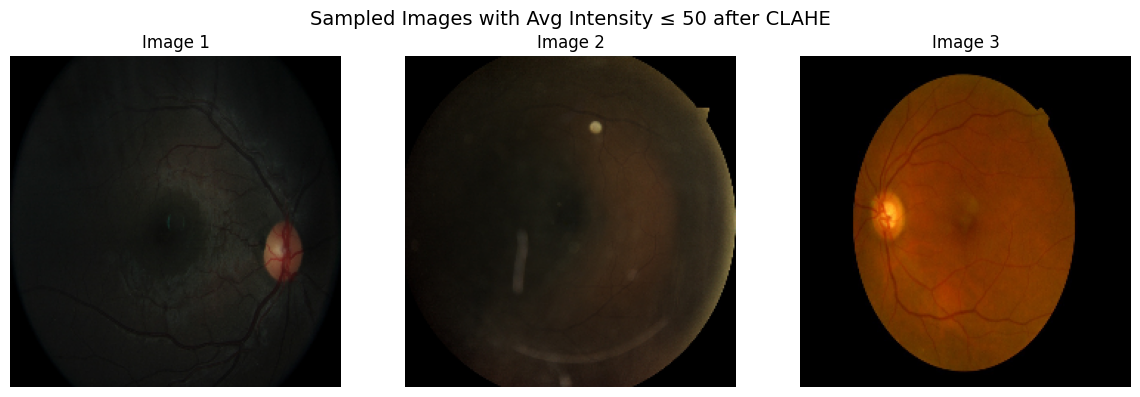

In [21]:
# Filter images with avg intensity ≤ 50
low_intensity_images = df_resized[df_resized["avg_intensity"] <= 50]

# Sample 3 random images from this set
sample_images = low_intensity_images.sample(n=min(3, len(low_intensity_images)), random_state=42)["resized_image"].tolist()

# Plot the sampled images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Sampled Images with Avg Intensity ≤ 50 after CLAHE", fontsize=14)

for i, img in enumerate(sample_images):
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].axis("off")
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

#### We see enhanced enderexposed images but the details are still not clear yet, lets apply gamma correction on it and see if its making any difference to it 

In [22]:
# Function to apply Gamma Correction
def apply_gamma_correction(img, gamma=1.5):
    """Applies gamma correction to an image"""
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)  # Apply lookup table transformation

gamma_corrected_images = []  # Store the corrected images separately

for i in tqdm(range(len(df_resized)), desc="Processing Remaining Dark Images"):
    img = df_resized.loc[i, "clahe_image"]  # Get the CLAHE-processed image
    avg_intensity = df_resized.loc[i, "avg_intensity"]  # Access precomputed intensity

    if avg_intensity < 43:  # If still too dark
        gamma_corrected_images.append(apply_gamma_correction(img, gamma=1.5))  # Apply gamma correction
    else:
        gamma_corrected_images.append(img)  # Keep unchanged

# Store corrected images in a new column
df_resized["gamma_corrected_image"] = gamma_corrected_images  

print("Gamma Correction applied to remaining dark images!")

Processing Remaining Dark Images: 100%|██████████| 90282/90282 [00:01<00:00, 46299.22it/s]

Gamma Correction applied to remaining dark images!


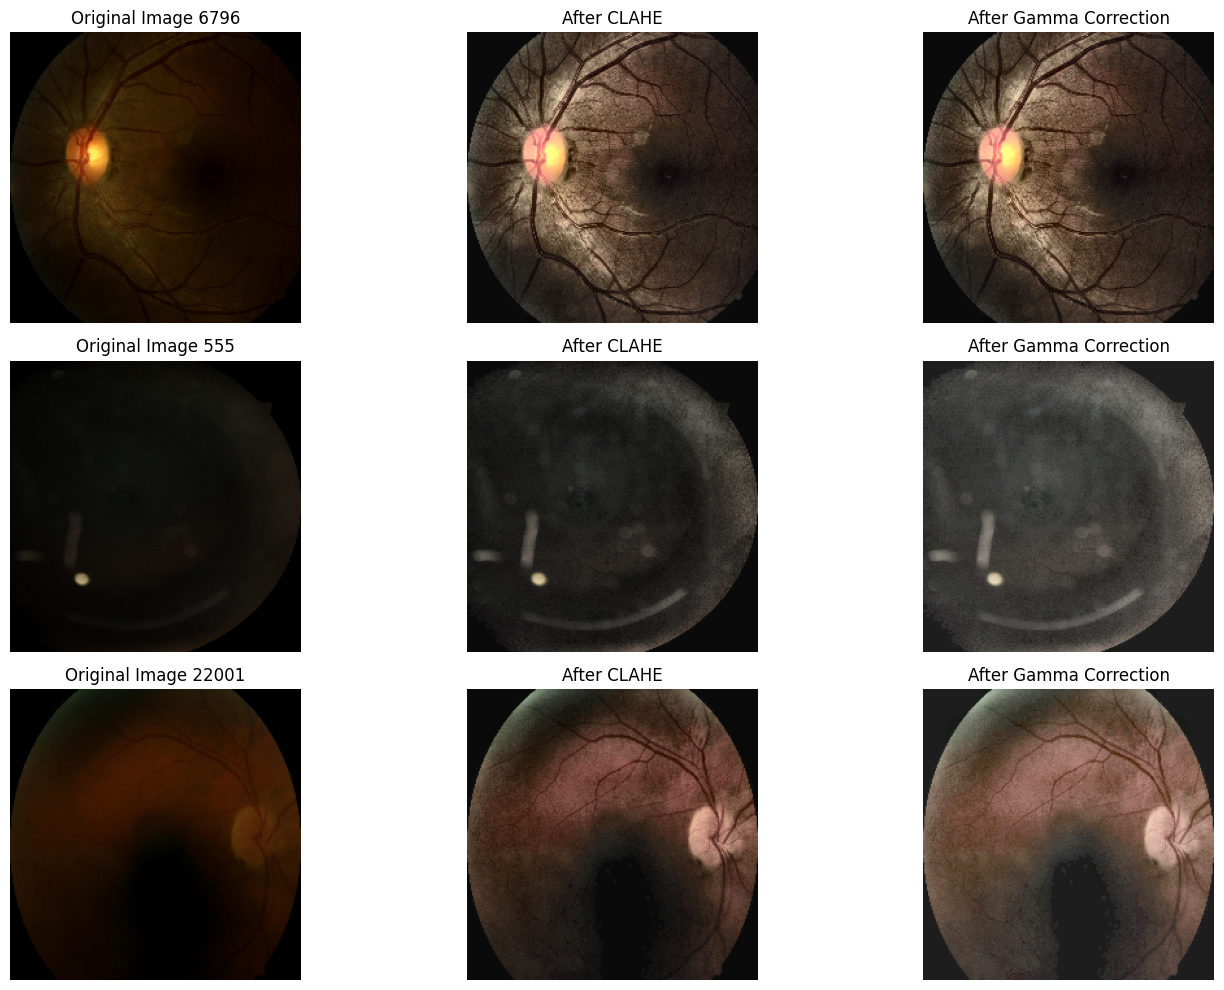

In [24]:
import random
import matplotlib.pyplot as plt
import cv2

def sample_images(df_resized):
    dark_indices = df_resized[df_resized["avg_intensity"] <= 50].index.tolist()
    
    selected_indices = random.sample(dark_indices, min(3, len(dark_indices))) # 3 images

    fig, axes = plt.subplots(len(selected_indices), 3, figsize=(15, 10))  

    if len(selected_indices) == 1:
        axes = [axes]  # Ensure axes is iterable if only one image is selected

    for i, idx in enumerate(selected_indices):
        original = df_resized.loc[idx, "resized_image"]
        clahe = df_resized.loc[idx, "clahe_image"]
        gamma_corrected = df_resized.loc[idx, "gamma_corrected_image"]

        axes[i][0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[i][0].set_title(f"Original Image {idx}")
        
        axes[i][1].imshow(cv2.cvtColor(clahe, cv2.COLOR_BGR2RGB))
        axes[i][1].set_title("After CLAHE")

        axes[i][2].imshow(cv2.cvtColor(gamma_corrected, cv2.COLOR_BGR2RGB))
        axes[i][2].set_title("After Gamma Correction")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

sample_images(df_resized)

In [26]:
df_resized['avg_intensity'].le(50).value_counts()

avg_intensity
False    88768
True      1514
Name: count, dtype: int64

In [27]:
import os
import cv2

# Define the folder to save images
save_folder = "dark_images"
os.makedirs(save_folder, exist_ok=True)  # Create folder if it doesn't exist

# Filter images where avg_intensity <= 50
dark_images_df = df_resized[df_resized["avg_intensity"] <= 50].copy()

# Save each image to the folder
for idx, row in dark_images_df.iterrows():
    image = row["resized_image"]
    image_path = os.path.join(save_folder, f"image_{idx}.png")
    cv2.imwrite(image_path, image)

print(f"Saved {len(dark_images_df)} dark images to '{save_folder}'")

Saved 1514 dark images to 'dark_images'
